In [37]:
import math
from numba import vectorize, cuda, jit
import numpy as np

In [32]:
print(cuda.gpus)

<Managed Device 0>


In [38]:
jit?

In [33]:
%%time
@vectorize(['float32(float32, float32, float32)',
            'float64(float64, float64, float64)'],
           target='cuda')
def cu_discriminant(a, b, c):
    return np.sqrt(b ** 2 - 4 * a * c)

N = 10000000
dtype = np.float32

# prepare the input
A = np.array(np.random.sample(N), dtype=dtype)
B = np.array(np.random.sample(N) + 10, dtype=dtype)
C = np.array(np.random.sample(N), dtype=dtype)

D = cu_discriminant(A, B, C)

print(D)  # print result

UntypedAttributeError: Failed at nopython (nopython frontend)
Unknown attribute 'sqrt' of type Module(<module 'numpy' from '/home/fei/miniconda3/envs/kaggle_ml/lib/python3.6/site-packages/numpy/__init__.py'>)
File "<timed exec>", line 5
[1] During: typing of get attribute at <timed exec> (5)

In [30]:
%%time
def cu_discriminant(a, b, c):
    return np.sqrt(b ** 2 - 4 * a * c)

N = 10000000
dtype = np.float32

# prepare the input
A = np.array(np.random.sample(N), dtype=dtype)
B = np.array(np.random.sample(N) + 10, dtype=dtype)
C = np.array(np.random.sample(N), dtype=dtype)

D = cu_discriminant(A, B, C)

print(D)  # print result

[10.878171 10.873273 10.107283 ... 10.346502 10.248876 10.705212]
CPU times: user 638 ms, sys: 99.2 ms, total: 738 ms
Wall time: 316 ms


In [7]:
%debug

> <timed exec>(2)cu_discriminant()

ipdb> a
a = array([0.79053485, 0.40779763, 0.6046494 , ..., 0.15152942, 0.5936449 ,
       0.44273648], dtype=float32)
b = array([10.901057, 10.925828, 10.888807, ..., 10.376974, 10.080226,
       10.659589], dtype=float32)
c = array([0.7669541 , 0.9988278 , 0.3085568 , ..., 0.33168656, 0.73564315,
       0.42848018], dtype=float32)
ipdb> q


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
import pickle

# Prepare data

In [2]:
hdf_path = '../derived_data/source.hdf'

In [3]:
%%time
train = pd.read_hdf(hdf_path, key='train')

CPU times: user 238 ms, sys: 1.86 s, total: 2.1 s
Wall time: 2.12 s


In [4]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [5]:
train.set_index('click_time', inplace=True)

In [6]:
gc.collect()

0

In [7]:
train = train.loc['2017-11-08 00:00:00':'2017-11-08 23:59:59'].copy()

In [8]:
gc.collect()

26

In [9]:
train.head()

,ip,app,device,os,channel,is_attributed
click_time,,,,,,
2017-11-08,48240,23,1,13,153,0
2017-11-08,45702,13,1,16,477,0
2017-11-08,123214,12,1,13,259,0
2017-11-08,98052,15,1,19,265,0
2017-11-08,97903,6,1,18,125,0


In [10]:
uint8_max = np.iinfo(np.uint8).max
uint16_max = np.iinfo(np.uint16).max
uint32_max = np.iinfo(np.uint32).max
def choose_int_type(n):
    if n <= uint8_max:
        return 'uint8'
    elif n <= uint16_max:
        return 'uint16'
    elif n <= uint32_max:
        return 'uint32'
    else:
        return 'uint64'

In [11]:
def rolling_count(df, time_win='1h'):
    return df.groupby(level=0, sort=False).size().rolling(time_win).sum()

In [12]:
gc.collect()

0

In [13]:
def process(df, features, time_win='1h'):
    res = df.reset_index()
    for feature in features:
        print('Processing {feature}'.format(feature=feature))
        if isinstance(feature, str):
            feature = [feature]
        elif isinstance(feature, list):
            pass
        else:
            print('Skip invalid feature!')
            continue
        tmp = df.groupby(feature, sort=False).apply(rolling_count, time_win=time_win)
        tmp = tmp.astype(choose_int_type(tmp.max()))
        tmp.name = 'n_' + '_'.join(feature)
        tmp = tmp.reset_index()
        res = res.merge(tmp, on=['click_time']+feature, how='left')
        del tmp
        gc.collect()
    return res

In [14]:
features = ['ip', 'app', 'device', 'os', 'channel']
feature_combos = list(combinations(features, 1)) + list(combinations(features, 2))

In [16]:
feature_combos = [list(feature_combo) for feature_combo in feature_combos]

In [17]:
feature_combos

[['ip'],
 ['app'],
 ['device'],
 ['os'],
 ['channel'],
 ['ip', 'app'],
 ['ip', 'device'],
 ['ip', 'os'],
 ['ip', 'channel'],
 ['app', 'device'],
 ['app', 'os'],
 ['app', 'channel'],
 ['device', 'os'],
 ['device', 'channel'],
 ['os', 'channel']]

In [19]:
%%time
train = process(train, feature_combos, time_win='30min')

Processing ['ip']
Processing ['app']
Processing ['device']
Processing ['os']
Processing ['channel']
Processing ['ip', 'app']
Processing ['ip', 'device']
Processing ['ip', 'os']
Processing ['ip', 'channel']
Processing ['app', 'device']
Processing ['app', 'os']
Processing ['app', 'channel']
Processing ['device', 'os']
Processing ['device', 'channel']
Processing ['os', 'channel']
CPU times: user 2h 19min 2s, sys: 3min, total: 2h 22min 2s
Wall time: 2h 18min 28s


In [20]:
gc.collect()

64

In [21]:
train.head()

,click_time,ip,app,device,os,channel,is_attributed,n_ip,n_app,n_device,...,n_ip_app,n_ip_device,n_ip_os,n_ip_channel,n_app_device,n_app_os,n_app_channel,n_device_os,n_device_channel,n_os_channel
0,2017-11-08,48240,23,1,13,153,0,1,19,734,...,1,1,1,1,19,3,19,167,39,7
1,2017-11-08,45702,13,1,16,477,0,1,19,734,...,1,1,1,1,19,1,13,7,17,1
2,2017-11-08,123214,12,1,13,259,0,1,102,734,...,1,1,1,1,99,29,9,167,13,4
3,2017-11-08,98052,15,1,19,265,0,3,96,734,...,2,3,2,1,95,24,9,211,11,6
4,2017-11-08,97903,6,1,18,125,0,2,13,734,...,1,2,2,1,13,1,8,50,8,1


In [22]:
gc.collect()

72

In [ ]:
valid = train.loc[train.click_time >= '2017-11-08 00:00:00'].copy()

In [18]:
train = train.loc[train.click_time <= '2017-11-07 23:59:59'].copy()

In [19]:
gc.collect()

24

In [20]:
train.head()

,click_time,ip,app,device,os,channel,is_attributed,n_ip,n_app,n_channel
0,2017-11-07,70712,2,1,32,237,0,1,84,5
1,2017-11-07,45892,3,1,25,424,0,1,96,6
2,2017-11-07,37774,8,2,13,145,0,2,41,41
3,2017-11-07,41179,2,1,13,122,0,1,84,15
4,2017-11-07,83111,15,1,8,245,0,1,91,33


In [21]:
gc.collect()

0

In [58]:
train = pd.read_hdf('../derived_data/rolling_window.hdf', key='train')

In [59]:
valid = pd.read_hdf('../derived_data/rolling_window.hdf', key='valid')

In [ ]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]

In [60]:
train.loc[:, 'hour'] = train.click_time.dt.hour.astype('uint8')
train.loc[:, 'minute'] = train.click_time.dt.minute.astype('uint8')
train.loc[:, 'in_test_hh'] = (
    3 - 2*train.hour.isin(most_freq_hours_in_test_data) - 1*train.hour.isin(least_freq_hours_in_test_data)
).astype('uint8')
train.loc[:, 'day_section'] = (train.hour // 6).astype('uint8')

In [67]:
valid.loc[:, 'hour'] = valid.click_time.dt.hour.astype('uint8')
valid.loc[:, 'minute'] = valid.click_time.dt.minute.astype('uint8')
valid.loc[:, 'in_test_hh'] = (
    3 - 2*valid.hour.isin(most_freq_hours_in_test_data) - 1*valid.hour.isin(least_freq_hours_in_test_data)
).astype('uint8')
valid.loc[:, 'day_section'] = (valid.hour // 6).astype('uint8')

In [68]:
train.drop(['ip', 'click_time'], axis=1, inplace=True)

In [69]:
valid.drop(['ip', 'click_time'], axis=1, inplace=True)

In [70]:
gc.collect()

513

In [40]:
train.to_hdf('../derived_data/rolling_window.hdf', key='train', mode='w')
valid.to_hdf('../derived_data/rolling_window.hdf', key='valid')

In [23]:
train, valid = train_test_split(train, test_size=0.05, stratify=train.is_attributed)

In [24]:
train.shape

(59797821, 22)

In [26]:
train.is_attributed.value_counts(normalize=True)

0    0.997564
1    0.002436
Name: is_attributed, dtype: float64

In [27]:
valid.shape

(3147254, 22)

In [28]:
valid.is_attributed.value_counts(normalize=True)

0    0.997564
1    0.002436
Name: is_attributed, dtype: float64

In [29]:
gc.collect()

13

# Light GBM

In [71]:
train.columns

Index(['app', 'device', 'os', 'channel', 'is_attributed', 'n_ip', 'n_app',
       'n_device', 'n_os', 'n_channel', 'n_ip_app', 'n_ip_device', 'n_ip_os',
       'n_ip_channel', 'n_app_device', 'n_app_os', 'n_app_channel',
       'n_device_os', 'n_device_channel', 'n_os_channel', 'hour', 'minute',
       'in_test_hh', 'day_section'],
      dtype='object')

In [72]:
target = 'is_attributed'

In [73]:
predictors = train.columns.tolist()

In [74]:
predictors.remove(target)

In [75]:
predictors

['app',
 'device',
 'os',
 'channel',
 'n_ip',
 'n_app',
 'n_device',
 'n_os',
 'n_channel',
 'n_ip_app',
 'n_ip_device',
 'n_ip_os',
 'n_ip_channel',
 'n_app_device',
 'n_app_os',
 'n_app_channel',
 'n_device_os',
 'n_device_channel',
 'n_os_channel',
 'hour',
 'minute',
 'in_test_hh',
 'day_section']

In [76]:
categorical = ['app', 'device', 'os', 'channel', 'hour', 'minute', 'in_test_hh', 'day_section']

In [77]:
gc.collect()

0

In [85]:
params = {
    'boosting_type': 'gbdt',  # I think dart would be better, but takes too long to run
    'drop_rate': 0.1,  # Rate at which to drop trees
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 20,  # Was 255: Reduced to control overfitting
    'max_depth': 8,  # Was 8: LightGBM splits leaf-wise, so control depth via num_leaves
    'min_child_samples': 100,
    'max_bin': 100,
    'subsample': 0.7,  # Was 0.7
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 300
}

In [56]:
dtrain = lgb.Dataset(
    train.loc[:, predictors],
    label=train.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

dvalid = lgb.Dataset(
    valid.loc[:, predictors],
    label=valid.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

In [59]:
gc.collect()

51

In [87]:
%%time
lgb_model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=900,
    categorical_feature=categorical
)

CPU times: user 1h 5min 52s, sys: 7min 10s, total: 1h 13min 2s
Wall time: 18min 20s


In [60]:
%%time
evals_results = {}
lgb_model = lgb.train(
    params, 
    dtrain, 
    valid_sets= [dtrain, dvalid], 
    valid_names=['train', 'valid'], 
    evals_result=evals_results, 
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=10, 
    feval=None
)

/home/fei/miniconda3/envs/kaggle_ml/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/fei/miniconda3/envs/kaggle_ml/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[10]	train's auc: 0.961978	valid's auc: 0.963576
[20]	train's auc: 0.964149	valid's auc: 0.965568
[30]	train's auc: 0.968454	valid's auc: 0.969697
[40]	train's auc: 0.969794	valid's auc: 0.971006
[50]	train's auc: 0.970879	valid's auc: 0.972038
[60]	train's auc: 0.971512	valid's auc: 0.972627
[70]	train's auc: 0.972055	valid's auc: 0.973138
[80]	train's auc: 0.972505	valid's auc: 0.97354
[90]	train's auc: 0.972807	valid's auc: 0.97379
[100]	train's auc: 0.973119	valid's auc: 0.974015
[110]	train's auc: 0.973394	valid's auc: 0.97417
[120]	train's auc: 0.973622	valid's auc: 0.974383
[130]	train's auc: 0.973808	valid's auc: 0.974589
[140]	train's auc: 0.973972	valid's auc: 0.974685
[150]	train's auc: 0.974132	valid's auc: 0.974761
[160]	train's auc: 0.974255	valid's auc: 0.974836
[170]	train's auc: 0.974391	valid's auc: 0.974961
[180]	train's auc: 0.974545	valid's auc: 0.975055
[190]	train's auc: 0.974642	valid's auc: 0.975131


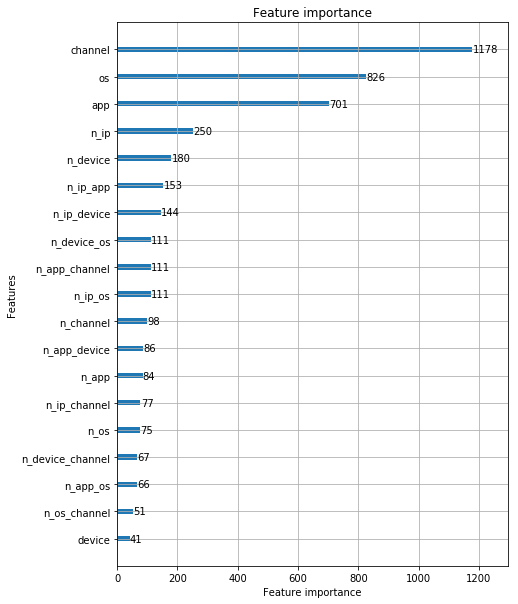

In [61]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

In [65]:
pred = lgb_model.predict(valid.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [66]:
pred.shape

(3147254,)

In [67]:
valid.loc[:, 'pred1'] = pred

In [68]:
valid.head()

,click_time,ip,app,device,os,channel,is_attributed,n_ip,n_app,n_device,...,n_ip_device,n_ip_os,n_ip_channel,n_app_device,n_app_os,n_app_channel,n_device_os,n_device_channel,n_os_channel,pred
14839506,2017-11-08 04:26:06,79827,2,1,49,219,0,826,240218,1676223,...,777,8,10,233039,825,17960,4988,24110,56,0.055222
14136297,2017-11-08 04:14:14,4019,6,2,19,459,0,726,21080,44566,...,48,109,23,735,4530,13406,6109,800,6927,0.007393
26045122,2017-11-08 07:57:47,49186,3,1,30,205,0,54,407540,1539308,...,53,3,1,399638,2182,10687,9179,30616,290,0.003859
6912737,2017-11-08 02:07:02,86729,15,1,13,265,0,63,125841,1410510,...,63,29,5,122781,27158,9897,311861,39900,9658,0.050335
11903636,2017-11-08 03:33:21,22691,2,1,17,212,0,42,204868,1492922,...,42,26,12,199090,10337,8655,77973,10862,594,0.011114


In [69]:
roc_auc_score(valid.loc[:, target], pred)

0.9762747715085776

In [16]:
with open('../results/rolling_window_combo2_day8.pickle', 'rb') as f:
    lgb_model = pickle.load(f)

In [17]:
pred = lgb_model.predict(train.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [57]:
train_pred = train.pred1.tolist()

In [36]:
pred = pd.Series(pred, name='pred1')

In [37]:
pred.shape

(59797821,)

In [21]:
train = train.reset_index(drop=True)

In [23]:
train.head()

,app,device,os,channel,is_attributed,n_ip,n_app,n_device,n_os,n_channel,n_ip_app,n_ip_device,n_ip_os,n_ip_channel,n_app_device,n_app_os,n_app_channel,n_device_os,n_device_channel,n_os_channel
0,18,1,13,121,0,198,72550,921767,212475,32351,11,177,58,3,71163,15249,26583,204675,31321,6904
1,3,1,13,173,0,13,84102,399792,93752,3460,2,13,13,1,80561,19810,2630,90751,3450,781
2,3,1,19,442,0,6,340343,1433991,366284,28185,2,6,3,1,329692,83070,10629,359449,27270,7204
3,3,1,19,115,0,81,325737,1445761,368632,9684,24,81,15,1,318852,82419,7709,363713,9474,2318
4,18,1,17,121,0,29,155211,1697018,96345,53961,10,25,8,9,152029,8255,40016,90557,52023,2970


In [41]:
gc.collect()

115

In [42]:
train1 = train.join(pred)

In [44]:
train = train1.copy()

In [45]:
gc.collect()

73

In [46]:
pred = lgb_model.predict(valid.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [48]:
pred = pd.Series(pred, name='pred1')

In [49]:
valid = valid.reset_index(drop=True)

In [50]:
valid = valid.join(pred)

In [51]:
predictors.append('pred1')

In [87]:
dtrain = lgb.Dataset(
    train.loc[:, predictors],
    label=train.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

dvalid = lgb.Dataset(
    valid.loc[:, predictors],
    label=valid.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

In [88]:
gc.collect()

59

In [89]:
%%time
evals_results = {}
lgb_model = lgb.train(
    params, 
    dtrain, 
    valid_sets= [dtrain, dvalid], 
    valid_names=['train', 'valid'], 
    evals_result=evals_results, 
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=10, 
    feval=None
)

/home/fei/miniconda3/envs/kaggle_ml/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/fei/miniconda3/envs/kaggle_ml/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[10]	train's auc: 0.967871	valid's auc: 0.969244
[20]	train's auc: 0.970721	valid's auc: 0.97153
[30]	train's auc: 0.972187	valid's auc: 0.972867
[40]	train's auc: 0.973296	valid's auc: 0.973753
[50]	train's auc: 0.974317	valid's auc: 0.974634
[60]	train's auc: 0.975129	valid's auc: 0.975106
[70]	train's auc: 0.975806	valid's auc: 0.975573
[80]	train's auc: 0.976384	valid's auc: 0.975842
[90]	train's auc: 0.97679	valid's auc: 0.975946
[100]	train's auc: 0.977245	valid's auc: 0.976075
[110]	train's auc: 0.977666	valid's auc: 0.976205
[120]	train's auc: 0.978074	valid's auc: 0.976312
[130]	train's auc: 0.978418	valid's auc: 0.976371
[140]	train's auc: 0.978723	valid's auc: 0.976441
[150]	train's auc: 0.979078	valid's auc: 0.976451
[160]	train's auc: 0.979361	valid's auc: 0.976472
[170]	train's auc: 0.979634	valid's auc: 0.976454
[180]	train's auc: 0.979883	valid's auc: 0.976435
[190]	train's auc: 0.980163	valid's auc: 0.976408

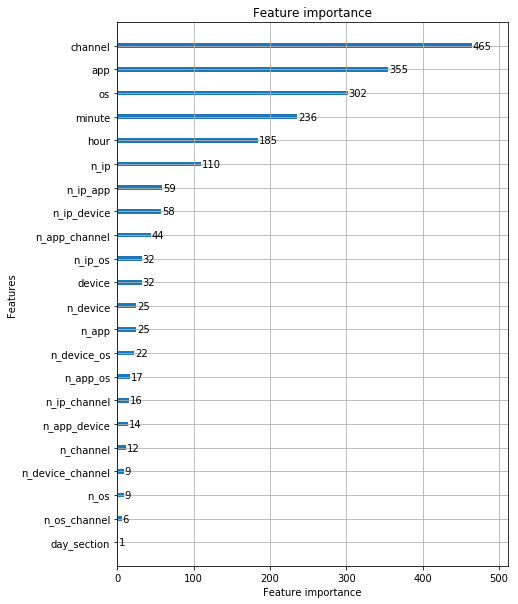

In [81]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

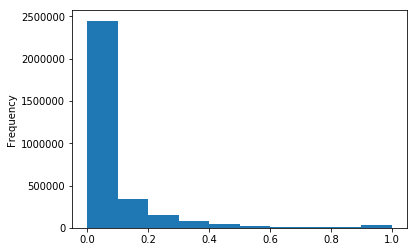

In [83]:
pred.plot(kind='hist')

In [84]:
(pred > 0.5).value_counts(normalize=True)

False    0.97434
True     0.02566
Name: pred1, dtype: float64

In [65]:
pred = lgb_model.predict(valid.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [ ]:
roc_auc_score(valid.loc[:, target], pred)

In [70]:
import pickle

In [71]:
with open('../results/rolling_window_combo2_day8.pickle', 'wb') as f:
    pickle.dump(lgb_model, f)

In [34]:
with open('../results/rolling_window.pickle', 'rb') as f:
    lgb_model = pickle.load(f)

In [35]:
pred = lgb_model.predict(train.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [36]:
roc_auc_score(train.loc[:, target], pred)

0.9763103757568603